# Create zonal statistics and point extractions for comparing CONUS404 and reference datasets

Short paragraph describing what is about to happen

<details>
  <summary>Guide to pre-requisites and learning outcomes...&lt;click to expand&gt;</summary>
  
  <table>
    <tr>
      <td>Pre-Requisites
      <td>To get the most out of this notebook, you should already have an understanding of these topics: 
        <ul>
        <li>pre-req one
        <li>pre-req two
        </ul>
    <tr>
      <td>Expected Results
      <td>At the end of this notebook, you should be able to: 
        <ul>
        <li>outcome one
        <li>outcome two
        </ul>
  </table>
</details>

In [2]:
# library imports
import fsspec #testing
import hvplot.xarray #testing
import intake #testing
import os #testing
import warnings #testing
import rioxarray #testing
import dask #testing
import metpy #testing
import calendar #testing

from shapely.geometry import Polygon #testing
from dask.distributed import LocalCluster, Client #testing
from pygeohydro import pygeohydro #testing
from fsspec.implementations.ftp import FTPFileSystem #testing
from holoviews.streams import PolyEdit, PolyDraw #testing
from geocube.api.core import make_geocube #testing

import xarray as xr #testing
import geopandas as gpd #testing
import pandas as pd #testing
import geoviews as gv #testing
import dask.dataframe as dd #testing
import numpy as np #testing

warnings.filterwarnings('ignore')

# Update to helper function after repo consolidation
## **Start a Dask client using an appropriate Dask Cluster** 
This is an optional step, but can speed up data loading significantly, especially when accessing data from the cloud.

In [ ]:
def configure_cluster(machine):
    ''' Helper function to configure cluster
    '''
    if machine == 'denali':
        from dask.distributed import LocalCluster, Client
        cluster = LocalCluster(threads_per_worker=1)
        client = Client(cluster)
    
    elif machine == 'tallgrass':
        from dask.distributed import Client
        from dask_jobqueue import SLURMCluster
        cluster = SLURMCluster(queue='cpu', cores=1, interface='ib0',
                               job_extra=['--nodes=1', '--ntasks-per-node=1', '--cpus-per-task=1'],
                               memory='6GB')
        cluster.adapt(maximum_jobs=30)
        client = Client(cluster)
        
    elif machine == 'local':
        import os
        import warnings
        from dask.distributed import LocalCluster, Client
        warnings.warn("Running locally can result in costly data transfers!\n")
        n_cores = os.cpu_count() # set to match your machine
        cluster = LocalCluster(threads_per_worker=n_cores)
        client = Client(cluster)
        
    elif machine in ['esip-qhub-gateway-v0.4']:   
        import sys, os
        sys.path.append(os.path.join(os.environ['HOME'],'shared','users','lib'))
        import ebdpy as ebd
        aws_profile = 'nhgf-development'
        ebd.set_credentials(profile=aws_profile)

        aws_region = 'us-west-2'
        endpoint = f's3.{aws_region}.amazonaws.com'
        ebd.set_credentials(profile=aws_profile, region=aws_region, endpoint=endpoint)
        worker_max = 30
        client,cluster = ebd.start_dask_cluster(profile=aws_profile, worker_max=worker_max, 
                                              region=aws_region, use_existing_cluster=True,
                                              adaptive_scaling=False, wait_for_cluster=False, 
                                              worker_profile='Medium Worker', propagate_env=True)
        
    return client, cluster

### Setup your cluster

#### QHub...
Uncomment single commented spaces (#) to run

In [ ]:
# set machine
machine = 'esip-qhub-gateway-v0.4'

# use configure cluster helper function to setup dask
client, cluster = configure_cluster(machine)

#### or HPC
Uncomment single commented spaces (#) to run

In [ ]:
## set machine
# machine = os.environ['SLURM_CLUSTER_NAME']

## use configure_cluster helper function to setup dask
# client, cluster = configure_cluster(machine)

## **Compute zonal statistics for gridded datasets**

In the last tutorial, we prepared three gridded datasets: CONUS404 (benchmark), PRISM (reference), and CERES-EBAF (reference). The goal of this section is compute [zonal statistics](https://gisgeography.com/zonal-statistics/) for each HUC6 zone in the Delaware River Basin (DRB) at each time-step in the data. This tabular data will then be exported for use in the next notebook, **CONUS404 Analysis**.

The steps for each dataset will be something like this:
1. Read in the prepared dataset
2. Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset
3. Make a data mask with the HUC6 boundaries to calculate zonal statistics
4. Compute zonal statistics with data mask and prepared data

Once the first 4 steps have completed for each dataset: 

5. Combine all three zonal statistics into single dataset
6. Export gridded data zonal statistics
<br>

**CONUS404 zonal statistics**

In [ ]:
# url to c404_drb
c404_drb_url = 's3://nhgf-development/workspace/tutorial/CONUS404/c404_drb.nc'

# open dataset
c404_drb = xr.open_dataset(c404_drb_url, cache=False, decode_cf=True, decode_coords="all")

c404_drb

Set the CRS

In [ ]:
# set crs
c404_crs = c404_drb["RNET"].metpy.cartopy_crs

Read in HUC6 boundaries

,geometry,huc6,name
0,"POLYGON ((-74.59840 42.45930, -74.60130 42.461...",020401,Upper Delaware
1,"POLYGON ((-75.93127 40.88437, -75.93681 40.885...",020402,Lower Delaware


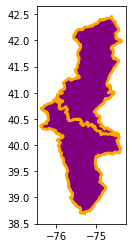

In [16]:
# bring in HUC6 boundaries found in the DRB
drb = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])

# set CRS to match c404_drb
# drb = drb.to_crs(c404_crs)

#visualize
drb.plot(edgecolor="orange", facecolor="purple", linewidth=2.5)

drb.head()

Create datamask and build new dataset

In [18]:
# convert huc6 field to int as this works best for the following steps
drb["huc6"] = drb["huc6"].astype(int) #note: this may drop the # of digits from 6 to less depending on how many zeroes there were, may need to pad back to 6 digits later

In [8]:
# create an output grid
c404_out_grid = make_geocube(
    vector_data = drb,
    measurements=["huc6"],
    like=c404_drb
)

# add datarrays to grid
c404_out_grid["RNET"] = (c404_drb.RNET.dims, c404_drb.RNET.values, 
                         c404_drb.RNET.attrs, c404_drb.RNET.encoding)

c404_out_grid["TK"] = (c404_drb.TK.dims, c404_drb.TK.values,
                         c404_drb.TK.attrs, c404_drb.TK.encoding)

c404_out_grid["PREC_NC_ACC"] = (c404_drb.PREC_NC_ACC.dims, c404_drb.PREC_NC_ACC.values,
                         c404_drb.PREC_NC_ACC.attrs, c404_drb.PREC_NC_ACC.encoding)


geometry    geometry
huc6           int32
name          object
dtype: object

Group data arrays by HUC6 code

In [ ]:
c404_grouped = c404_out_grid.drop("spatial_ref").groupby(c404_out_grid.huc6)

## **Putting it together: Process CONUS404 to variable and research spatial extent**
In this section we are going to put together some skills we have learned so far: bring in CONUS404, select our variables, then clip to our spatial extent. This assumes that the notebook is being run on the ESIP QHub. If being run on HPC then comment/uncomment the datasets as needed.

Variables: Accumulated precipitation (PREC_ACC_NC), air temperature (TK), and (calculated) surface net radiation (RNET) <br>
Spatial extent: Delaware River Basin (DRB)<br>

In [ ]:
# set up conus404 filename
conus404 = 'conus404-hourly-cloud' #ESIP QHub
# conus404 = 'conus404-hourly-onprem' #HPC

# create dask array from dataset
ds = cat[conus404].to_dask()

# parse spatial information from CF conventions
ds = ds.metpy.parse_cf()

Get the coordinate reference system (CRS) information from CONUS404 dataset to use when setting the CRSs for other datasets

In [ ]:
crs = ds["TK"].metpy.cartopy_crs
# crs

Other datasets that that are brought in might need to be sliced to the same time period as the CONUS404 dataset. Set the start and end dates for the CONUS404 dataset to use later.

In [ ]:
# get the minimum time coordinate
start_date = ds.coords["time"].values.min()

# convert to datetime then extract the year-month as a string "YYYYmm"
start_date = pd.to_datetime(start_date).strftime("%Y-%m")

# add the first day of the month to the date
start_date = f"{start_date}-01"

# get the maximum time coordinate
end_date = ds.coords["time"].values.max()

# convert to datetime then extract the year-month as a string "YYYYmm"
end_date = pd.to_datetime(end_date).strftime("%Y-%m")

# as the end date of months vary, use the monthrange function, which returns a tuple of integers as (firstDay, lastDay)
# extract the lastDay integer by indexing [1] and convert it to string
last_day = calendar.monthrange(int(end_date[0:4]), int(end_date[-2:]))[1]
last_day = str(last_day) 

# add last_data to end_date                         
end_date = f"{end_date}-{last_day}"

print("Start date:", start_date, "\nEnd date:", end_date)

Now bring in the AOI boundaries

Create a subset of desired data variables

In [ ]:
#subset data variables
c404_variables = ["PREC_ACC_NC", "TK", "ACSWDNB", "I_ACSWDNB", "ACSWUPB", "I_ACSWUPB", "ACLWDNB", "I_ACLWDNB", "ACLWUPB", "I_ACLWUPB"]
c404 = ds[c404_variables]

# write CRS
c404.rio.write_crs(crs, inplace=True)

# perform clip
c404_drb = c404.rio.clip(drb.geometry, crs=crs, drop=True, invert=False)

Visualize the results

In [ ]:
# c404_drb["ACSWDNB"].isel(time=-1).hvplot(x='x', y='y', crs=crs, rasterize=True, cmap='turbo', tiles='OSM')

We have a little more processing to do before the dataset is ready for analysis. We need to:
1. Calcuate RNET using the radiation columns
2. Resample and aggregate the data to the desired time-step (1 month)

RNET is calculated using the equation <br>
RNET = SWDN + LWDN - SWUP - LWUP

SWDN = downwelling surface flux of shortwave radiation <br>
LWDN = downwelling surface flux of longwave radiation <br>
SWUP = upwelling surface flux of shortwave radiation <br>
LWUP = upwelling surface flux of longwave radiation <br>

Each of the RNET component pieces is calculated using different data variables.

Lets break down the components. First, let's tackle SWDN, which is computed from ACSWDNB and I_ACSWDNB (accumulations in units of J/m2).  To compute SWDN in W/m2
over one hour we use:

(ACSWDNB[h]+(1e9xI_ACSWDNB[h])) - (ACSWDNB[h-1]+(1e9xI_ACSWDNB[h-1])) / 3600

which uses the data variables at the time hour (h) and the previous hour (h-1). The I_ variables are also scaled by multiplying by 1e9.

We want all values for ACSWDNB and I_ACSWDNB starting at time index h where h is the second time step since indices start at 0....

In [ ]:
ACSWDNB = c404_drb["ACSWDNB"][1:]

I_ACSWDNB = c404_drb["I_ACSWDNB"][1:]

and we want all values for ACSWDNB and I_ACSWDNB at time index h-1. However, we want the time indexes for both our h and h-1 datasets to be the same (this makes a difference in calculations).

In [ ]:
ACSWDNB1 = c404_drb["ACSWDNB"][:-1]
ACSWDNB1.coords["time"] = ACSWDNB.coords["time"]

I_ACSWDNB1 = c404_drb["I_ACSWDNB"][:-1]
I_ACSWDNB1.coords["time"] = I_ACSWDNB.coords["time"]

Confirm both time coords are the same length.

In [ ]:
len(ACSWDNB.coords["time"].values) == len(ACSWDNB1.coords["time"].values)

Multiply the *I_* arrays by 1e9

In [ ]:
# h
I_ACSWDNB_1e9 = 1e9*I_ACSWDNB

# h-1
I_ACSWDNB1_1e9 = 1e9*I_ACSWDNB1

Now calculate SWDN

In [ ]:
SWDN = ((ACSWDNB + I_ACSWDNB_1e9) - (ACSWDNB1 + I_ACSWDNB1_1e9)) / 3600

Let's visualize some of the results.

In [ ]:
# SWDN.sel(time="2000-06-01 10:00").hvplot(x='x', y='y', crs=crs, rasterize=True, cmap='turbo', tiles='OSM')

In [ ]:
# SWDN.sel(time="2000-06-01 23:00").hvplot(x='x', y='y', crs=crs, rasterize=True, cmap='turbo', tiles='OSM')

Next, pad a NaN to the beginning to match original datasets dimension length and then reset to those dimensions

In [ ]:
SWDN = SWDN.pad({"time":(1,0)})
SWDN.coords["time"] = c404_drb["ACSWDNB"].coords["time"]

Now, we will do the same steps to calculate the other three building blocks of *RNET*.

*SWUP*

(ACSWUPB[h]+(1e9xI_ACSWUPB[h])) - (ACSWUPB[h-1]+(1e9xI_ACSWUPB[h-1])) / 3600

In [ ]:
# (h) variables
ACSWUPB = c404_drb["ACSWUPB"][1:]

I_ACSWUPB = c404_drb["I_ACSWUPB"][1:]

# (h-1) variables)
ACSWUPB1 = c404_drb["ACSWUPB"][:-1]
ACSWUPB1.coords["time"] = ACSWUPB.coords["time"]

I_ACSWUPB1 = c404_drb["I_ACSWUPB"][:-1]
I_ACSWUPB1.coords["time"] = I_ACSWUPB.coords["time"]

# modify bucket variables by 1e9
I_ACSWUPB_1e9 = 1e9*I_ACSWUPB
I_ACSWUPB1_1e9 = 1e9*I_ACSWUPB1

# calculate variable
SWUP = ((ACSWUPB + I_ACSWUPB_1e9) - (ACSWUPB1 + I_ACSWUPB1_1e9)) / 3600

# pad to match c404_drb time dimension
SWUP = SWUP.pad({"time":(1,0)})
SWUP.coords["time"] = c404_drb["ACSWUPB"].coords["time"]

*LWDN*

(ACLWDNB[h]+(1e9xI_ACLWDNB[h])) - (ACLWDNB[h-1]+(1e9xI_ACLWDNB[h-1])) / 3600

In [ ]:
# (h) variables
ACLWDNB = c404_drb["ACLWDNB"][1:]

I_ACLWDNB = c404_drb["I_ACLWDNB"][1:]

# (h-1) variables)
ACLWDNB1 = c404_drb["ACLWDNB"][:-1]
ACLWDNB1.coords["time"] = ACLWDNB.coords["time"]

I_ACLWDNB1 = c404_drb["I_ACLWDNB"][:-1]
I_ACLWDNB1.coords["time"] = I_ACLWDNB.coords["time"]

# modify bucket variables by 1e9
I_ACLWDNB_1e9 = 1e9*I_ACLWDNB
I_ACLWDNB1_1e9 = 1e9*I_ACLWDNB1

# calculate variable
LWDN = ((ACLWDNB + I_ACLWDNB_1e9) - (ACLWDNB1 + I_ACLWDNB1_1e9)) / 3600

# pad to match c404_drb time dimension
LWDN = LWDN.pad({"time":(1,0)})
LWDN.coords["time"] = c404_drb["ACLWDNB"].coords["time"]

*LWUP*

(ACLWUPB[h]+(1e9xI_ACLWUPB[h])) - (ACLWUPB[h-1]+(1e9xI_ACLWUPB[h-1])) / 3600

In [ ]:
# (h) variables
ACLWUPB = c404_drb["ACLWUPB"][1:]

I_ACLWUPB = c404_drb["I_ACLWUPB"][1:]

# (h-1) variables)
ACLWUPB1 = c404_drb["ACLWUPB"][:-1]
ACLWUPB1.coords["time"] = ACLWUPB.coords["time"]

I_ACLWUPB1 = c404_drb["I_ACLWUPB"][:-1]
I_ACLWUPB1.coords["time"] = I_ACLWUPB.coords["time"]

# modify bucket variables by 1e9
I_ACLWUPB_1e9 = 1e9*I_ACLWUPB
I_ACLWUPB1_1e9 = 1e9*I_ACLWUPB1

# calculate variable
LWUP = ((ACLWUPB + I_ACLWUPB_1e9) - (ACLWUPB1 + I_ACLWUPB1_1e9)) / 3600

# pad to match c404_drb time dimension
LWUP = LWUP.pad({"time":(1,0)})
LWUP.coords["time"] = c404_drb["ACLWUPB"].coords["time"]

With all the parts, calculate RNET..

In [ ]:
# calculate
RNET = SWDN + LWDN - SWUP - LWUP
# RNET

...assign its attributes...

In [ ]:
# dictionary of attributes
RNET_attrs = {'description': 'NET RADIATION FROM PAST HOUR FOR BUCKET',
 'grid_mapping': 'crs',
 'long_name': 'Bucket net radiation',
 'units': 'W m-2'
}

# assign attributes
RNET = RNET.assign_attrs(RNET_attrs)
# RNET

 and assign it back to CONUS404

In [ ]:
c404_drb = c404_drb.assign(RNET=RNET)

Now drop the extra radiation variables

In [ ]:
c404_variables_drop = ["ACSWDNB", "I_ACSWDNB", "ACSWUPB", "I_ACSWUPB", "ACLWDNB", "I_ACLWDNB", "ACLWUPB", "I_ACLWUPB"]
c404_drb = c404_drb.drop_vars(c404_variables_drop)

Visualize RNET

In [ ]:
# c404_drb["RNET"].sel(time="2000-06-01 23:00").hvplot(x='x', y='y', crs=crs, rasterize=True, cmap='turbo', tiles='OSM')

Our dataset has been clipped to the area of interest and all the needed variables calculated. The final bit of engineering is resampling the data from hourly to monthly. Xarray has a built in method `resample()` to do this but it only allows a single aggregation method for all the DataArrays in the DataSet. 

Unfortunately, the DataArrays need different aggregation techniques: sum for *PREC_ACC_NC* and mean for *RNET* and *TK*. We'll accomplish this by splitting *PREC_ACC_NC* from the dataset, resampling it and the dataset seperately, then merging them back together.

In [ ]:
# copy data
PREC_ACC_NC = c404_drb["PREC_ACC_NC"]

# resample to 1 month by summing
PREC_ACC_NC = PREC_ACC_NC.resample(time="1M").sum()

# copy attributes from original
PREC_ACC_NC.attrs = c404_drb["PREC_ACC_NC"].attrs

# drop from c404_drb
c404_drb = c404_drb.drop_vars("PREC_ACC_NC")

Resample the dataset and aggregate by mean.

In [ ]:
with xr.set_options(keep_attrs=True): # needed, otherwise drops attributes
    c404_drb = c404_drb.resample(time="1M").mean()

Add back the resampled *PREC_ACC_NC*

In [ ]:
c404_drb["PREC_ACC_NC"] = PREC_ACC_NC
# c404_drb

Correct attributes as needed

In [ ]:
c404_drb.PREC_ACC_NC.attrs["integration_length"] = 'accumulated over prior month'
c404_drb.RNET.attrs["description"] = "MEAN RADIATION FROM PAST MONTH FOR BUCKET"
c404_drb.TK.attrs["description"] = "MEAN AIR TEMPERATURE AT THE LOWEST MODEL LEVEL OVER THE PREVIOUS MONTH"

Drop coordinates that will not be need in the exported dataset

In [ ]:
c404_drb = c404_drb.reset_coords(["metpy_crs", "crs"], drop=True)

Set chunk size so entire dataset is single chunck (the data is small enought)

In [ ]:
c404_drb = c404_drb.chunk(chunks={
    "y":103,
    "x":46,
    "time":492
})

Review the final prepared dataset

In [ ]:
c404_drb

Export data as a NetCDF file

In [ ]:
outfile = fsspec.open('simplecache::s3://nhgf-development/workspace/tutorial/CONUS404/c404_drb.nc', 
                      mode='wb', s3=dict(profile='nhgf-development'))
with outfile as f:
    c404_drb.load().to_netcdf(f, compute=True)

### Prepare reference data

Now that the CONUS404 dataset has been preprocessed, we need to do the same with datasets used for comparison with the forcings data. In this section, data will be brought in from several sources and preprocessed in data-type-appropriate ways.

We'll start by processing station data.

#### NOAA's Global Historical Climate Network - Daily (GHCN) Dataset
It is always important to review any readme or metadata files for the data you wish to bring in. The [GHCN readme](https://noaa-ghcn-pds.s3.amazonaws.com/readme.txt) is useful because it explains what is in the S3 bucket, the various columns in the datasets, and other information. When we later call in the observational data, the [by station readme](https://noaa-ghcn-pds.s3.amazonaws.com/readme-by_station.txt) provides a more detailed explanation of the data there.

The steps for working the the GHCN data will be that we first read in the data that describe the stations (metadata); then we'll read in time-series data for each station.

After reading the metadata for the file, we can see that only the first three columns are needed to map the stations: the station ID, latitude, and longitude. However, we want to make sure that we are only using GHCN stations so we need to also use the (G)HCN/CRN Flag column to filter to GHCN sites. 

Start by getting a list of stations from the AWS S3 bucket where the daily data is housed.

In [ ]:
ghcn_all = pd.read_csv('s3://noaa-ghcn-pds/ghcnd-stations.txt', sep="\t", header=None)
# ghcn_all.head(2)

As you can see, the read does not recognize the file's columns and the dare are stored as one column per record. So, we have to split the record to create the columns that we need.

In [ ]:
ghcn_all = ghcn_all[0].str.split(" +",expand = True)
# ghcn_all.head(2)

Columns 0-3 now look as we'd expect. However, column 4 is where it starts to get messy as the method for expanding the columns has split up the station names at the spaces between. This means that the HCN flag, which we would expect to be in column 6, could be in columns 6-13. Thankfully, the pandas ```loc``` function makes this filtering easy.

In [ ]:
ushcn = ghcn_all.loc[(ghcn_all[6] == "HCN") | (ghcn_all[7] == "HCN") | (ghcn_all[8] == "HCN") | (ghcn_all[9] == "HCN") | (ghcn_all[10] == "HCN") | (ghcn_all[11] == "HCN") | (ghcn_all[12] == "HCN") | (ghcn_all[13] == "HCN")].copy()
ushcn = ushcn.iloc[:, 0:3].rename({0:"station", 1:"lat", 2:"lon"}, axis=1).copy() # after the search, trim the columns and rename to get the data to what is needed to map
# ushcn.head()

We now need to clip the points to only those in the DRB. We do that by using the latitude and longitude to create a GeoDataFrame...

In [ ]:
ushcn_gdf = gpd.GeoDataFrame(ushcn, geometry=gpd.points_from_xy(ushcn['lon'], ushcn['lat'], crs="EPSG:4326"))

# convert to same crs as drb
ushcn_gdf = ushcn_gdf.to_crs(crs)

# ushcn_gdf.plot()

...followed by clipping using the *drb* geodataframe above.

In [ ]:
hcn_drb_gdf = gpd.clip(ushcn_gdf, drb)
# hcn_drb_gdf.plot()

Now we want to pull in the tabular data for all of the DRB stations. These are stored on AWS in an individual CSV for each station named *station.csv*. So, we need to get all of the station IDs from our dataset and use them to create a list of URLs for these.

In [ ]:
hcn_drb_data_url = [f"s3://noaa-ghcn-pds/csv/by_station/{station}.csv" for station in hcn_drb_gdf["station"].unique().tolist()]
# print(hcn_drb_data_url[0:3])

In [ ]:
# len(hcn_drb_data_url)

We'll now pass that list of URLs to *dask.dataframe.read_csv*, which will read the data in parallel. We'll then refine the entries to in the temporal range of CONUS404.

In [ ]:
storage_options = dict(anon=True, requester_pays=False)
hcn_drb_data = dd.read_csv(hcn_drb_data_url, parse_dates=["DATE"], 
                           usecols=["ID", "DATE", "ELEMENT", "DATA_VALUE"], storage_options=storage_options)

hcn_drb_data = hcn_drb_data.loc[(hcn_drb_data["DATE"] >= start_date) & (hcn_drb_data["DATE"] <= end_date)]

Next, we'll refine the dataframe by a list of elements and then compute it.

##### Note: We are using TMAX and TMIN rather than TAVG as TAVG has no records prior to 1998.

In [ ]:
# list of elements we are interested in
element_list = ["PRCP", "TMAX", "TMIN"]

hcn_drb_data = hcn_drb_data.loc[hcn_drb_data["ELEMENT"].isin(element_list)]

In [ ]:
# check shape
# hcn_drb_data.compute().shape

In [ ]:
# how much memory does it take up?
# hcn_drb_data.compute().memory_usage()

The dask dataframe is about 21 mb in size.

Similar to the CONUS404 data, we have a little more engineering to do with the data. We need to calculate the average temperatue using TMIN and TMAX (in Kelvin) as well as resample the data to a 1 month interval. We'll convert the Dask Dataframe into a Pandas Dataframe to do this.

In [ ]:
hcn_drb_data_df = hcn_drb_data.compute()

We start by whittling down to our two temperature elements, dropping the *ELEMENT* column, and grouping our data by *ID* and *DATE* in order to take the mean of *TMIN* and *TMAX* and convert this to degrees Kelvin.

In [ ]:
# paring down data
hcn_drb_tk = hcn_drb_data_df.loc[hcn_drb_data_df["ELEMENT"].isin(["TMAX","TMIN"])]

# dropping ELEMENT
hcn_drb_tk = hcn_drb_tk.drop("ELEMENT", axis=1)

# calculate mean temperature for each station and date
hcn_drb_tk = hcn_drb_tk.groupby(["ID", "DATE"]).mean()

# rename the DATA_VALUE column to TK
hcn_drb_tk = hcn_drb_tk.rename({"DATA_VALUE":"TK"}, axis=1)

# convert from tenths of degrees Celsius to degrees Kelvin
hcn_drb_tk["TK"] = (hcn_drb_tk["TK"] * 0.1) + 273.15

# reset the index
hcn_drb_tk.reset_index(inplace=True)

Isolate the *PRCP* element and rename like TK

In [ ]:
hcn_drb_prcp = hcn_drb_data_df.loc[hcn_drb_data_df["ELEMENT"] == "PRCP"].copy()

# dropping ELEMENT
hcn_drb_prcp = hcn_drb_prcp.drop("ELEMENT", axis=1)

# rename the DATA_VALUE column to PREC_ACC_NC
hcn_drb_prcp = hcn_drb_prcp.rename({"DATA_VALUE":"PREC_ACC_NC"}, axis=1)

# convert from tenths of mm to mm
hcn_drb_prcp["PREC_ACC_NC"] = hcn_drb_prcp["PREC_ACC_NC"] * 0.1

# reset the index
hcn_drb_prcp.reset_index(inplace=True, drop=True)

# hcn_drb_prcp

Combine *TK* and *PRCP* DataFrames

In [ ]:
hcn_drb = hcn_drb_tk.merge(hcn_drb_prcp, how="inner", on=["ID", "DATE"])
# hcn_drb

And then resample to 1 month and aggregate

In [ ]:
hcn_drb = hcn_drb.groupby("ID").resample("1M", on="DATE").agg({"TK":"mean", "PREC_ACC_NC":"sum"}).reset_index(drop=False)

# round TK
hcn_drb.TK = round(hcn_drb.TK, 2)
# hcn_drb

Now add the latitude and longitude coordinates 

In [ ]:
hcn_drb_coords = pd.DataFrame(hcn_drb_gdf.drop(columns="geometry"))

# rename ID columnt o match drb_hcn
hcn_drb_coords = hcn_drb_coords.rename({"station": "ID", "lon":"LONGITUDE", "lat":"LATITUDE"}, axis=1)

# merge
hcn_drb = hcn_drb.merge(hcn_drb_coords, on="ID", how="left")

hcn_drb.head()

Export the dataset

In [ ]:
hcn_drb.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/hcn_drb.parquet")

#### NOAA's Global Climate Reference Network (GCRN) Dataset

Use *fsspec* to make FTP call to NOAA for CRN data <br>
First, create file system

In [ ]:
fs = FTPFileSystem("ftp.ncei.noaa.gov")

Since the file type is *tab-separated values (tsv)*, we will use the *pd.read_table* function to create a Dataframe

In [ ]:
uscrn_all = pd.read_table(fs.open("/pub/data/uscrn/products/stations.tsv")) 
uscrn_all.head()

Now turn into GeoDataFrame.

In [ ]:
uscrn_gdf = gpd.GeoDataFrame(uscrn_all, geometry=gpd.points_from_xy(uscrn_all["LONGITUDE"], uscrn_all["LATITUDE"]), crs="EPSG:4326")

# convert to same crs as drb
uscrn_gdf = uscrn_gdf.to_crs(crs)

# uscrn_gdf.plot()

Find which USCRN sites are in DRB

In [ ]:
crn_drb_gdf = gpd.clip(uscrn_gdf, drb)
# crn_drb_gdf.plot()

In [ ]:
crn_drb_gdf.head()

We now know what CRN sites are in the Delaware River Basin. We must now retrieve the data for this site from the FTP server.

First, we'll get the location name.

In [ ]:
crn_stat_name = crn_drb_gdf["LOCATION"].values.tolist()[0]
print(crn_stat_name)

Initilize the FTP connection again

In [ ]:
fs = FTPFileSystem("ftp.ncei.noaa.gov")

In [ ]:
file_list_glob = fs.glob(
    f"/pub/data/uscrn/products/daily01/**/*{crn_stat_name}*")

In [ ]:
crn_drb = pd.DataFrame()

for file in file_list_glob:
    stat_data = pd.read_csv(fs.open(file), header=None, sep="\t")
    crn_drb = pd.concat([crn_drb, stat_data])

In [ ]:
crn_drb = crn_drb[0].str.split(" +",expand = True)
# crn_drb.head()

Now bring in the headers for the station data

In [ ]:
crn_headers = fs.open("/pub/data/uscrn/products/daily01/headers.txt")
crn_data_headers = pd.read_csv(crn_headers, sep="\t", header=None).iloc[1,:].str.split(" +").values.tolist()[0][0:28]
# crn_data_headers

Check that the number of headers equals the number of columns in our data

In [ ]:
print(len(crn_drb.columns) == len(crn_data_headers))

Now rename the column headers

In [ ]:
crn_drb.columns = crn_data_headers
# crn_drb

The *LST_DATE* column is the date of the observation and its data type is currently string. We want the data type to be [datetime](https://docs.python.org/3/library/datetime.html) so we will perform this conversion using the `to_datetime` function from the `pandas` library then refine the columns.

In [ ]:
crn_drb["DATE"] = pd.to_datetime(crn_drb["LST_DATE"])
crn_drb = crn_drb[["DATE", "P_DAILY_CALC", "T_DAILY_AVG", "SOLARAD_DAILY", "LONGITUDE", "LATITUDE"]]

If you examine the data types, you'll see that the 4 columns of numbers are actually data type *object* when we need them as numeric

In [ ]:
crn_drb.dtypes

Lets rectify that by applying the `pd.to_numeric` function to the columns.

In [ ]:
cols = crn_drb.columns.drop("DATE")
crn_drb[cols] = crn_drb[cols].apply(pd.to_numeric, errors='coerce')
crn_drb.dtypes

Now refine the data by date

In [ ]:
crn_drb = crn_drb.loc[(crn_drb["DATE"] >= start_date) & (crn_drb["DATE"] <= end_date)]

The CRN dataset has many values of -9999.0, which is where a record was not recorded due to data quality or other issues. 

In [ ]:
crn_drb.head(2)

Because the value -9999.0 is seen as a valid number, set these values to NaN so they will be ignored during calculations.

In [ ]:
# set to NaN
crn_drb = crn_drb.replace(-9999.0, np.nan)

# add a station ID column
crn_drb["ID"] = crn_stat_name

Now convert columns to the correct units

In [ ]:
# Celsius to Kelvin
crn_drb["TK"] = crn_drb["T_DAILY_AVG"] + 273.15

# MJ/m2 to W/m2
crn_drb["RNET"] = (crn_drb["SOLARAD_DAILY"]*1e6) / 86400 # converts MJ/m2 to W/m2

# drop columns
crn_drb = crn_drb.drop(["T_DAILY_AVG","SOLARAD_DAILY"], axis=1)

# rename column
crn_drb = crn_drb.rename({"P_DAILY_CALC": "PREC_ACC_NC"}, axis=1)

Resample the data and round TK and RNET

In [ ]:
crn_drb = crn_drb.groupby("ID").resample("1M", on="DATE").agg({"TK":"mean", "PREC_ACC_NC":"sum", "RNET":"mean", "LATITUDE":"mean", "LONGITUDE":"mean"}).reset_index(drop=False)

# round 
crn_drb["RNET"] = round(crn_drb["RNET"], 2)
crn_drb["TK"] = round(crn_drb["TK"], 2)

crn_drb

Export the dataset

In [ ]:
crn_drb.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/crn_drb.parquet")

#### PRISM data
This time we will open the PRISM dataset, temporarally slice it, spatially clip it, and refine the data. Many of the steps will look the same as the CONUS404 dataset  so there will be less explanation of the steps.

In [ ]:
fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

In [ ]:
prism_years = range(1979, 2021, 1)
chunks={"time": 6, "lon": 703, "lat": 311}
pr = [xr.open_dataset(fs.open(f"s3://nhgf-development/thredds/prism_v2/prism_{str(year)}.nc"), chunks=chunks, decode_coords="all") for year in prism_years]
prism = xr.concat(pr, dim="time")
prism = prism.drop_vars("time_bnds")

# prism

In [ ]:
# NAD83
prism_crs = 4269

# write crs to prism
prism.rio.write_crs(prism_crs, inplace=True)

Rename the dimensions to match CF conventions used by rioxarray

In [ ]:
prism = prism.rename({"lon":"x", "lat":"y", "ppt": "PREC_ACC_NC"}) 

Bring in DRB boundaries and reproject to match PRISM crs.

In [ ]:
# bring in boundaries of DRB and create single polygon
drb_NAD83 = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])
# create a column where all entries have the same value
drb_NAD83["name"] = "DRB"

# dissolve by that column
drb_NAD83 = drb_NAD83.dissolve(by="name")

# set CRS to match ds
drb_NAD83 = drb_NAD83.iloc[[0]].to_crs(prism_crs)

#visualize
# drb_NAD83.plot(edgecolor="orange", facecolor="purple", linewidth=2.5)

In [ ]:
# clip to DRB
prism_drb = prism.rio.clip(drb_NAD83.geometry, crs=prism_crs, drop=True, invert=False)

#slice time
prism_drb = prism_drb.sel(time=slice(start_date, end_date))

Display the clipped data

In [ ]:
# prism_drb.sel(time="2000-06-01", method="nearest").hvplot(x='x', y='y', geo=True, rasterize=True, tiles='OSM', alpha=0.7, cmap='turbo')

Calculate the mean monthly tempertaure and convert to Kelvin and populate its attributes

In [ ]:
# mean temperature in Kelvin
prism_drb = prism_drb.assign(TK = ((prism_drb.tmn+prism_drb.tmx)/2) + 273.15) 

# dictionary of attributes
prism_tk_attrs = {'units': 'K',
 'long_name': 'Mean monthly temperature'
}

# assign attributes
prism_drb["TK"] = prism_drb["TK"].assign_attrs(prism_tk_attrs)

prism_drb.PREC_ACC_NC.attrs["units"] = 'mm'
prism_drb.PREC_ACC_NC.attrs["long_name"] = 'Accumulated grid scale precipitation'

# drop variables
prism_drb = prism_drb.drop_vars(["tmn", "tmx"])

# drop spatial_ref coord in order to export later
prism_drb = prism_drb.reset_coords("spatial_ref", drop=True)

# rechunk to make export easier
prism_drb = prism_drb.chunk(chunks={
    "y":98,
    "x":48,
    "time":492
})

# check out final dataset
prism_drb

Export data as a NetCDF file

In [ ]:
outfile = fsspec.open('simplecache::s3://nhgf-development/workspace/tutorial/CONUS404/prism_drb.nc', 
                      mode='wb', s3=dict(profile='nhgf-development'))
with outfile as f:
    prism_drb.load().to_netcdf(f, compute=True)

#### NASA's CERES-EBAF Level 3b Dataset
The [CERES-EBAF Summary](https://ceres.larc.nasa.gov/documents/DQ_summaries/CERES_EBAF_Ed4.1_DQS.pdf) provides important background information and insights about the data. The [download page](https://ceres.larc.nasa.gov/data/#ebaf-level-3) provides a quicks summary as well.

In [ ]:
# bring in ceres-ebay
ceres = xr.open_dataset("https://opendap.larc.nasa.gov/opendap/CERES/EBAF/Edition4.1/CERES_EBAF_Edition4.1_200003-202111.nc", decode_coords="all")

# parse_cf
ceres = ceres.metpy.parse_cf()

# extract crs
ceres_crs = ceres.sfc_net_tot_all_mon.metpy.cartopy_crs

# rename
ceres = ceres.rename({"lon":"x", "lat":"y", "sfc_net_tot_all_mon":"RNET"}) 

# x is in 0:360, need it in -180:180
ceres = ceres.assign_coords(x=(((ceres.x + 180) % 360) - 180)).sortby('x')

# pare down dataset 
ceres = ceres["RNET"]

# set crs
ceres.rio.write_crs(ceres_crs, inplace=True)

# bring in boundaries of DRB and create single polygon
drb_PC = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])

# create a column where all entries have the same value
drb_PC["name"] = "DRB"

# dissolve by that column
drb_PC = drb_PC.dissolve(by="name")

# set CRS to match ds
drb_PC = drb_PC.iloc[[0]].to_crs(ceres_crs)

# clip to DRB
ceres_drb = ceres.rio.clip(drb_PC.geometry, crs=ceres_crs, drop=True, invert=False, all_touched=True)

#slice time
ceres_drb = ceres_drb.sel(time=slice(start_date, end_date))

# drop spatial_ref coord in order to export later
ceres_drb = ceres_drb.reset_coords(["spatial_ref", "metpy_crs"], drop=True)

#check final dataset
ceres_drb

Export the dataset

In [ ]:
outfile = fsspec.open('simplecache::s3://nhgf-development/workspace/tutorial/CONUS404/ceres_drb.nc', 
                      mode='wb', s3=dict(profile='nhgf-development'))
with outfile as f:
    prism_drb.load().to_netcdf(f, compute=True)

Make sure all files have been created. There should be:
1. c404_drb.nc
2. ceres_drb.nc
3. crn_drb.parquet
4. hcn_drb.parquet
6. prism_drb.nc

In [ ]:
fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

fs.ls("s3://nhgf-development/workspace/tutorial/CONUS404", detail=True)

In [ ]:
# # Last code cell of the notebook
# import watermark.watermark as watermark
# print(watermark(iversions=True, python=True, machine=True, globals_=globals()))

In [ ]:
client.close(); cluster.shutdown()